In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import astropy.units as u

Text(0, 0.5, 'Number of Flare Detections')

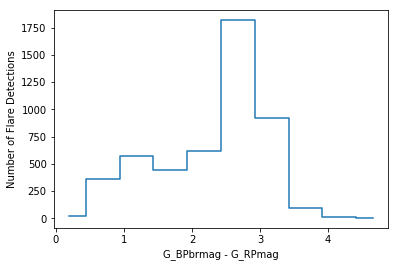

In [2]:
df_flare = pd.read_csv('1to13_filt_flare_out.csv')
# Measure flare energies from GAIA data
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
df_flare_g = pd.merge(tic_gaia_table, df_flare, on='TIC', how='inner')
df_flare_g = df_flare_g.dropna(subset=['lum'])

color = df_flare_g['G_BPbrmag'] - df_flare_g['G_RPmag']
hist, bins = np.histogram(color)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xlabel('G_BPbrmag - G_RPmag')
plt.ylabel('Number of Flare Detections')

In [3]:
color_bins = [0, 1, 2, 3, 4]

### Rotation period vs number of stars

Text(0, 0.5, 'Number of Stars')

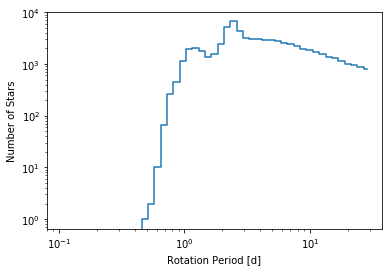

In [4]:
df = pd.read_csv('1to13_rot_param_out.csv')
rotbins = np.logspace(-1, np.log10(30))
hist, bins = np.histogram(df['rot_per'], bins=rotbins)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rotation Period [d]')
plt.ylabel('Number of Stars')

### CMD of flare stars

Text(0, 0.5, 'Gmag')

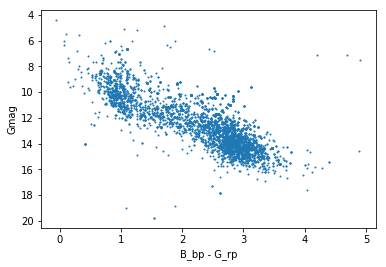

In [5]:
plt.scatter(color, df_flare_g['G_mag'], s=1)
plt.gca().invert_yaxis()
plt.xlabel('B_bp - G_rp')
plt.ylabel('Gmag')

### Rotation period vs flare rate

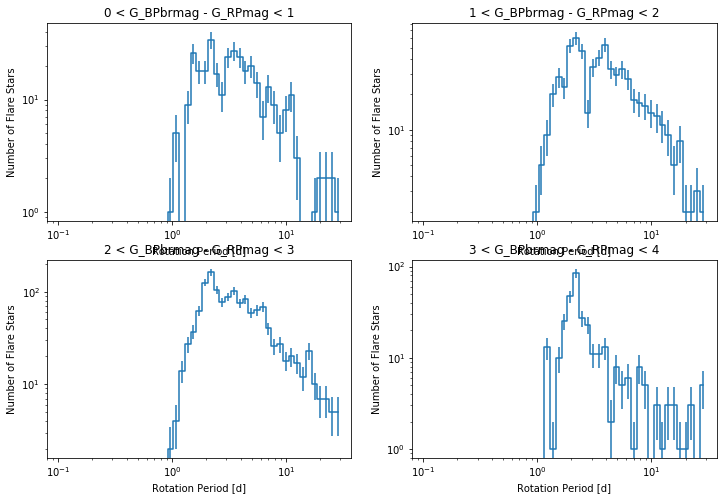

In [6]:
nc = len(color_bins)
fig, axes = plt.subplots(figsize=(12, nc//2*4), nrows=nc//2, ncols=2)
for idx in range(nc - 1):
    c1, c2 = color_bins[idx], color_bins[idx+1]
    mask = (color >= c1) & (color < c2)
    
    hist, bins = np.histogram(df_flare_g[mask]['rot_per'], bins=rotbins)
    bins = 0.5*(bins[1:] + bins[:-1])
    ax = axes[idx//2][idx%2]
    ax.errorbar(bins, hist, yerr=np.sqrt(hist), linestyle='steps-mid')
    ax.set_title(str(c1) + ' < G_BPbrmag - G_RPmag < ' + str(c2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Rotation Period [d]')
    ax.set_ylabel('Number of Flare Stars')

### FFD by color

In [7]:
from os import path
# One extra piece of information I need:
# How many days was each target observed by TESS?

# This is really slow, save the results to a file
if not path.exists('num_obs.txt'):
    # To start, get all of the TICs with a flare detection
    flare_tics = df_flare_g['TIC'].values.astype(int)

    # For each TIC, determine how many files are associated with it
    num_obs = np.zeros_like(flare_tics)
    # We can search all lines at once in the text file with pandas
    files = pd.read_csv('1to13_files.txt', header=None)

    for idx, TIC in enumerate(flare_tics):
        num_obs[idx] = len(np.where(files[0].str.contains(str(flare_tics[idx]).zfill(16)) == True)[0])

    np.savetxt('num_obs.txt', (flare_tics, num_obs))
    
else:
    flare_tics, num_obs = np.loadtxt('num_obs.txt')

(-2.5, 2)

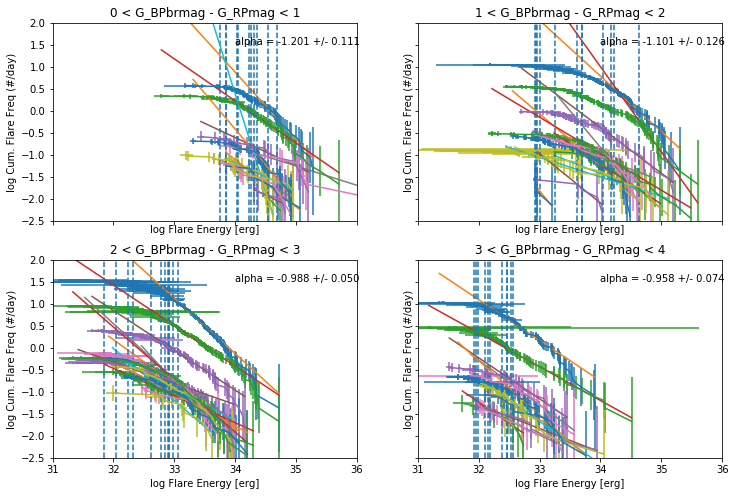

In [53]:
from FFD import FFD, FFD_powerlaw, FlareKernel

fig, axes = plt.subplots(figsize=(12, nc//2*4), nrows=nc//2, ncols=2, sharex=True, sharey=True)
for idx in range(nc - 1):
    c1, c2 = color_bins[idx], color_bins[idx+1]
    mask = (color >= c1) & (color < c2)
    ax = axes[idx//2][idx%2]
    
    b0_vals = []
    b0_err_vals = []
    
    for no in np.arange(1, np.max(num_obs)):
        tess_time = 23.4*no
        mask_no = np.isin(df_flare_g['TIC'], flare_tics[num_obs == no])
        df_sub = df_flare_g[mask_no]
        
        c1, c2 = color_bins[idx], color_bins[idx+1]
        color = df_sub['G_BPbrmag'] - df_sub['G_RPmag']
        mask = (color >= c1) & (color < c2)
        
        ed_vals = (df_sub['ed'].values*u.d).to(1*u.s).value
        ed_err_vals = (df_sub['ed_err'].values*u.d).to(1*u.s).value
        x, y, xe, ye = FFD(ed_vals[mask], edErr=ed_err_vals[mask], Lum=df_sub[mask]['lum'].values, TOTEXP=tess_time)
        
        if len(x) < 1:
            continue
        
        ax.errorbar(x, y, xerr=xe, yerr=ye)
        
        b0, b1, b0_err, b1_err, cutoff = FFD_powerlaw(x, y, xe, ye, findXmin=True)

        xmodel = np.linspace(np.min(x), np.max(x))
        ymodel = b0*xmodel + b1

        ax.plot(xmodel, ymodel)
        ax.axvline(cutoff, linestyle='--')
        
        b0_vals.append(b0)
        b0_err_vals.append(b0_err)
        
    ax.annotate('alpha = {:.3f}'.format(np.mean(b0_vals)) + ' +/- {:.3f}'.format(np.mean(b0_err_vals)), xy=(34, 1.5))
    
    ax.set_title(str(c1) + ' < G_BPbrmag - G_RPmag < ' + str(c2))
    ax.set_xlabel('log Flare Energy [erg]')
    ax.set_ylabel('log Cum. Flare Freq (#/day)')
ax.set_xlim(31, 36)
ax.set_ylim(-2.5, 2)